# Frente de Pareto
**Evaluación de conformaciones de CDK2 según su valor de AUC con el dataset CSAR**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Carga y muestra de los datos
data_dir = './B_DATOS'
df_cdk2_labels = pd.read_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json")
df_cdk2_labels.iloc[: , -8:].head(5)

,Inhib,Inhib_mass,Labels_conf,AUC_vrd_16x,AUC_vrd_8x,AUC_vina,AUC_ad4_LC,AUC_ad4_LE
1aq1,STU,440.0,inact_b,0.730317,0.740724,0.575339,0.634163,0.572172
1b38,ATP,398.0,inact_a,0.677828,0.683258,0.546154,0.571946,0.483032
1b39,ATP,398.0,inact_a,0.764706,0.785520,0.580543,0.670814,0.607919
1buh,,,inact_a,0.708145,0.734163,0.535294,0.613348,0.544344
1ckp,PVB,214.0,inact_a,0.766968,0.781900,0.571493,0.764932,0.715385


## Un primer análsis es la correlación de los rankings
### Correlación de Pearson y Spearman

In [3]:

# NOTA: Podríamos usar np.corrcoef, peron no devuelve p, y sólo computa Pearson
# Las matrices nos on muy grandes así que lo hacemos con dos ciclos anidados y en dos partes
df_auc_scores = df_cdk2_labels[['AUC_ad4_LE', 'AUC_ad4_LC', 
                'AUC_vina', 'AUC_vrd_8x', 'AUC_vrd_16x']]
# no obstante para extraer los valores p de la correlación, usaremos scipy

#### Es posible utilizar  el método corr() de pandas

In [4]:
mtx_cor_pearson = df_auc_scores.corr(method = 'pearson')

mtx_cor_sepearman = df_auc_scores.corr(method = 'spearman')

In [14]:
mtx_cor_pearson

,AUC_ad4_LE,AUC_ad4_LC,AUC_vina,AUC_vrd_8x,AUC_vrd_16x
AUC_ad4_LE,1.000000,0.897545,0.292637,0.616034,0.620263
AUC_ad4_LC,0.897545,1.000000,0.268382,0.624657,0.631929
AUC_vina,0.292637,0.268382,1.000000,0.531182,0.523890
AUC_vrd_8x,0.616034,0.624657,0.531182,1.000000,0.955277
AUC_vrd_16x,0.620263,0.631929,0.523890,0.955277,1.000000


In [13]:
mtx_cor_sepearman

,AUC_ad4_LE,AUC_ad4_LC,AUC_vina,AUC_vrd_8x,AUC_vrd_16x
AUC_ad4_LE,1.000000,0.905884,0.273622,0.615868,0.617034
AUC_ad4_LC,0.905884,1.000000,0.265574,0.642429,0.647881
AUC_vina,0.273622,0.265574,1.000000,0.520171,0.494863
AUC_vrd_8x,0.615868,0.642429,0.520171,1.000000,0.950113
AUC_vrd_16x,0.617034,0.647881,0.494863,0.950113,1.000000


#### No obstante, para extraer los valores p, usaremos scipy

In [5]:
# Extraemos el valor de correlación y el valor p entre cada par
n_values = df_auc_scores.shape[1]
# Creamos las matrices vacias
mtx_pearson_p = np.zeros((n_values, n_values))
mtx_spearman_p = np.zeros((n_values, n_values))

for i, i_data in enumerate(df_auc_scores):
    for j, j_data in enumerate(df_auc_scores):
        # Cálculo de Pearson
        r_P, p_P = stats.pearsonr(df_auc_scores[i_data], 
                               df_auc_scores[j_data])
        mtx_pearson_p[i, j] = p_P
        # Cálculo de Pearson
        r_S, p_S = stats.spearmanr(df_auc_scores[i_data], 
                       df_auc_scores[j_data])
        mtx_spearman_p[i, j] = p_S

In [6]:
# p-values
# H0: El coeficiente de correlación NO es diferente de 0 (muestras son independientes)
# Ha: r es distinto de cero (Muestras dependientes/ correlacionadas)

# Verificamos que los valores de correlación sean significativos
print(mtx_pearson_p.all() < 0.05)

print(mtx_spearman_p.all() < 0.05)
# Todos los valores p son menores a alfa = 0.05

True
True


### Gráfica de las correlaciones

In [11]:
import seaborn as sns
%matplotlib inline
sns.set( context = 'notebook', style = 'white', font_scale=1.2)

### Pairplot

In [9]:
# Añadimos una etiqueta a las conformaciones tal que podamos distinguir las activas de las inactivas
# Creamos las etiquetas
labels = ['CDK2 Activa' if i == 'active' else 'CDK Inactiva' for i in df_cdk2_labels.Labels_conf]
# La añadimos al dataframe
df_auc_scores_labels = df_auc_scores.copy()
df_auc_scores_labels['Labels'] = labels

<Figure size 864x864 with 0 Axes>

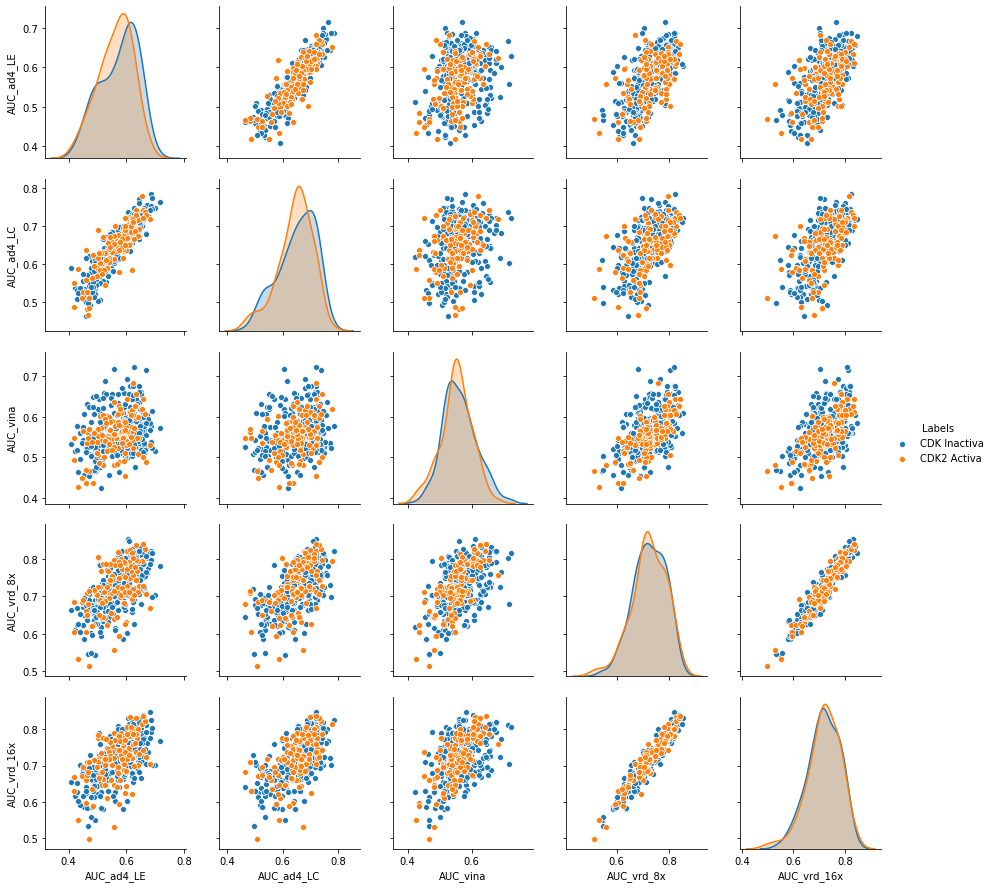

In [10]:
plt.figure(figsize=(12, 12))
pair_plot = sns.pairplot(df_auc_scores_labels, hue = 'Labels')
pair_plot;

> **La eqtiqueta del tipo de conformación no permite visualizar ningun patrón, no obstante quizá con posteriores análisis podamos identificar patrones en las conformaciones con mejor AUC, que permitan visualizar una distinción de éstas con respecto a las conformaciones con menor AUC.**

#### PENDIENTE:
Verificar si el volumen, la forma del pocket, un subconjunto de residuos de la proteína o quizá alguna otra característica de éstas permiten determinar qué las hace buenas para haber mejorado el ranking.

# Frente de Pareto

**Vamos a comenzar comparando dos métodos de scoring (el realidad el mismo)**
> ### Vinardo 8x vs AD4 LC

Dos objetivos:
    - AUC de vinardo 8x
    - AUC de AD4 LC

In [53]:
# Extraemos los vectores:
scores = df_cdk2_labels[['AUC_vrd_8x', 'AUC_ad4_LC']]

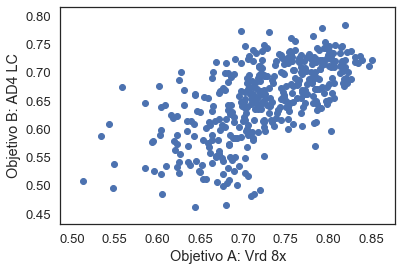

In [54]:
# Plot
plt.scatter(scores['AUC_vrd_8x'], scores['AUC_ad4_LC'])
plt.xlabel('Objetivo A: Vrd 8x')
plt.ylabel('Objetivo B: AD4 LC')
plt.show()

In [55]:
# Función para identificar los puntos que están el frente no dominado


In [69]:
def identify_pareto(scores):
    # Contamos el número de observaciones
    sample_size = scores.shape[0]
    # Indices para la muestra
    sample_ids = np.arange(sample_size)
    # Se crea una lista inicial de los elementos en el plt de Pareto
    # Todos los elementos se inicializan como parte del frente no dominado
    pareto_front = np.ones(sample_size, dtype = bool) # 1 = no-dominado
    # Se itera sobre cada elemento frente al resto de los demás
    for i in range(sample_size):
        for j in range(sample_size):
            # Comprueba si i es dominado por j
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                # j domina i, por tanto i no está en el frente. i = 0
                pareto_front[i] = 0
                # Para a la siguiente iteración
                break
    return(pareto_front)

In [83]:
def is_pareto_efficient_dumb(scores):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(scores.shape[0], dtype = bool)
    for i, s in enumerate(scores):
        # comprueba si el score (s) de i domina a los demás elementos
        is_efficient[i] = np.all(np.any(scores[:i] < s, axis=1)) and np.all(np.any(scores[i+1:] < s, axis=1))
    return is_efficient

In [79]:
a = identify_pareto(scores.to_numpy())

In [84]:
b = is_pareto_efficient_dumb(scores.to_numpy())

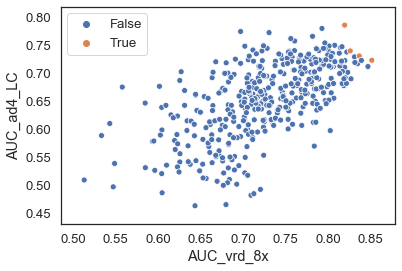

In [85]:
sns.scatterplot(scores['AUC_vrd_8x'], scores['AUC_ad4_LC'], hue=a)

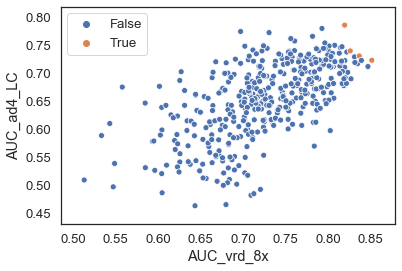

In [86]:
sns.scatterplot(scores['AUC_vrd_8x'], scores['AUC_ad4_LC'], hue=b)